## CS Templates Take 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from gwpy.timeseries import TimeSeries

In [2]:
from glitschen import *

In [3]:
#by default training will use a 0.5s window, centered.
W, Z = train_ppca('./data/L1O3a_Tomtes_10-128.npy', q=5, plots=True)

In [4]:
noiseseg = np.load('./data/L1O3a_ex_noise_64s_2048.npy')
noiseseg = noiseseg[0]
seglen = 64.0
times = np.linspace(-seglen/2, seglen/2, len(noiseseg))
noiseseg_ts = TimeSeries(noiseseg, times=times)
asd = noiseseg_ts.asd()
#just to obtain an asd to whiten with

In [5]:
def gen_noiseseg(seglen, srate=2048.):
    draws = np.random.normal(size=int(seglen*srate))
    times  = np.linspace(-seglen/2, seglen/2, int(seglen*srate))
    noiseseg_ts = TimeSeries(draws, times=times)
    return noiseseg_ts
#can generate gaussian noise or inject into the real noise

In [6]:
csdata = np.loadtxt('./data/cusp11.txt')
#this is a cosmic string waveform generated with LALsim.

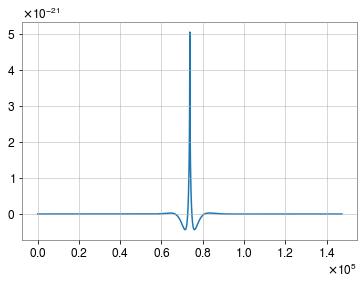

In [7]:
plt.plot(csdata)

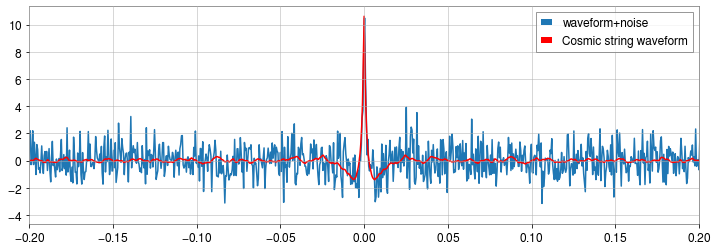

In [22]:
highpass = 10. #it's necessary to highpass, so that the signal isn't dominated by low-f content
#which isnt in the sensitive band of the detector, and whitening isnt effectively removing.
datasrate = 16384.
dataseglen = len(csdata)/datasrate
times = np.linspace(-dataseglen/2, dataseglen/2, len(csdata))
cs_timeseries = TimeSeries(csdata, times=times)
cs_timeseries = cs_timeseries.resample(2048)
csh = cs_timeseries.highpass(highpass)

cst_white = csh.whiten(asd=asd) #whiten using sample L1 noise

srate = 2048
noise = gen_noiseseg(len(cst_white)/srate)
inj = noise + cst_white
#injecting
plt.figure(figsize=(12,4))
plt.plot(inj, label='waveform+noise')
plt.plot(cst_white, color='red', label='Cosmic string waveform')
plt.xlim(-0.2,0.2)
plt.legend()


(-0.15, 0.15)

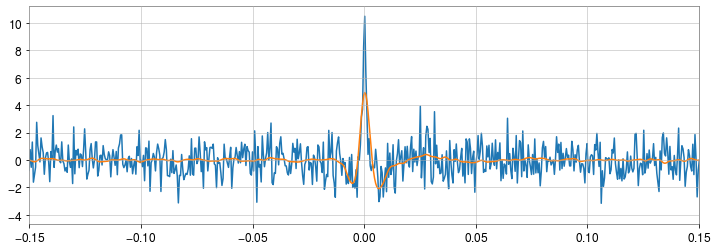

In [24]:
glitchrec = maxL_reconst(W, inj, fixed=False, gfrac=0.1, metric='ip')
glitchrects = TimeSeries(glitchrec, times=np.linspace(-len(cst_white)/srate/2, len(cst_white)/srate/2, int(len(cst_white))))
plt.figure(figsize=(12,4))
plt.plot(inj, label='Cosmic string injection')
plt.plot(glitchrects, label='glitschen tomte reconstruction') 
plt.xlim(-.15,.15)

In [25]:
mf_snr(inj, glitchrects)

<Quantity 14.86675395>

In [26]:
mf_snr(cst_white, cst_white)

<Quantity 17.95542267>

In [27]:
mf_snr(inj, glitchrects)/mf_snr(cst_white, cst_white)

<Quantity 0.82798129>

So 82% of the SNR is recovered, using the tomte model to fit a cosmic string template.

This is where the PPCA reconstruction parameters fall, with the whole training set in blue.

While the tomte model underperforms, we see that the blip model is capable of subtracting this waveform, indicating that blips will be very problematic for CS searches.

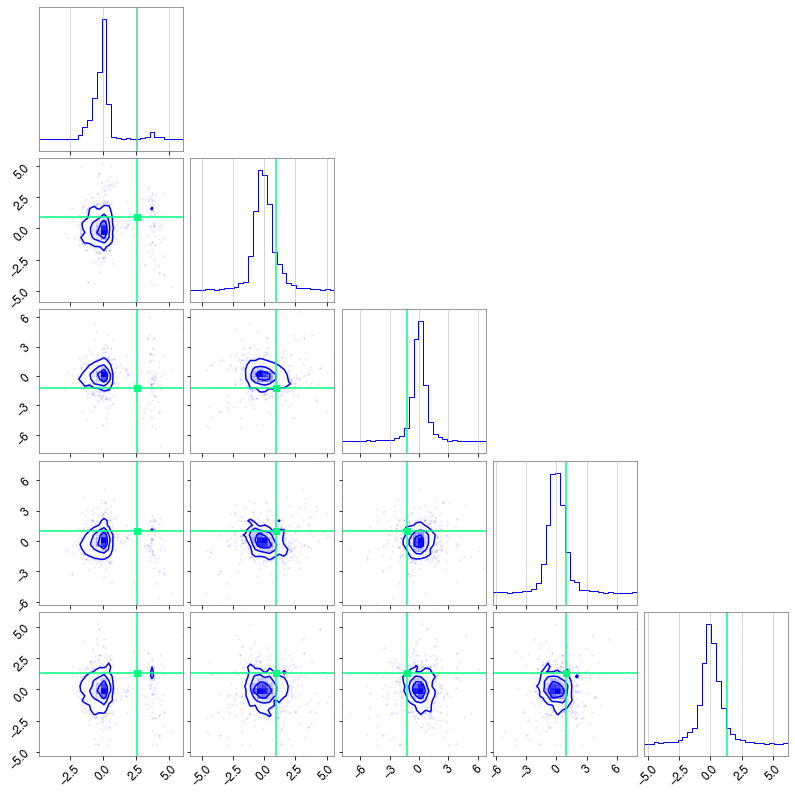

In [28]:
plot_corner_maxl(Z, W, inj)

## Outlier_score
We can use the best reconstruction weights along with the training set to obtain a statistic, on [0,1] that tells us how likely an event is to be associated with a glitch type. The process is as follows: 

1. Train on only half of the training data.
2. Use the remaining half to obtain best reconstructions of known glitches.
3. Calculate the logpdf of these glitches and plot a histogram.
4. The fraction of training glitches with larger logpdfs than the run segment determines the outlier score.

This works better for larger sets of glitches.

outlier_score:  0.0


0.0

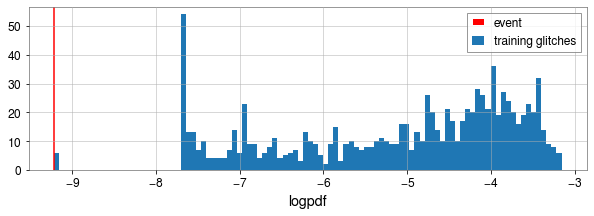

In [65]:
outlier_score('./data/L1O3a_Tomtes_10-128.npy', inj)

## Sampler
In many cases, sampling gives us a much more powerful result than a point reconstruction.

In [49]:
test_fd = np.fft.rfft(inj)
kdeprior = kombine.clustered_kde.optimized_kde(Z[:-1].T)
post = Posterior(test_fd, W, 2048, prior=kdeprior)

In [50]:
q=5
nwalkers=128
N=1000
p0 = initializer(nwalkers, timescale=0.2)

In [51]:
sampler = kombine.Sampler(nwalkers, q+1, post)

In [52]:
sampler.run_mcmc(N=N, p0=p0, update_interval=100)

(array([[ 8.49290464e-05,  2.66089422e+00,  8.28653573e-01,
         -1.13691769e+00,  1.21499255e+00,  1.14107880e+00],
        [ 1.16728821e-04,  2.59325271e+00,  1.20449153e+00,
         -1.18394654e+00,  9.45628279e-01,  1.57833353e+00],
        [-1.38356945e-04,  2.65110150e+00,  1.05028693e+00,
         -1.18112514e+00,  1.38746113e+00,  1.54992515e+00],
        ...,
        [-2.19505664e-04,  2.61202674e+00,  9.44311882e-01,
         -1.46337824e+00,  9.82545202e-01,  1.73141130e+00],
        [ 1.33895929e-05,  2.69628162e+00,  1.19905794e+00,
         -9.15852985e-01,  1.46055342e+00,  1.39733516e+00],
        [-3.08036358e-04,  2.59438194e+00,  9.78057762e-01,
         -1.14797643e+00,  1.74779802e+00,  1.72132666e+00]]),
 array([-9277.67967148, -9277.36478848, -9275.32229523,
        -9276.58612976, -9276.82833112, -9275.70118905,
        -9276.42647365, -9277.4740332 , -9275.25372491,
        -9275.55594894, -9275.74805272, -9277.16849052,
        -9276.85492309, -9278.61728

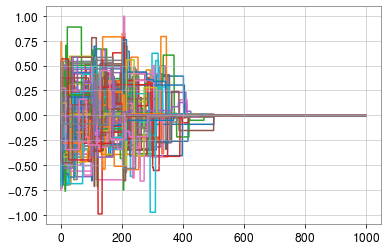

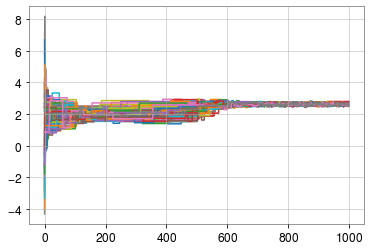

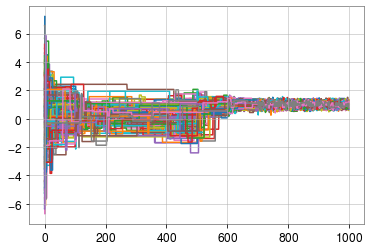

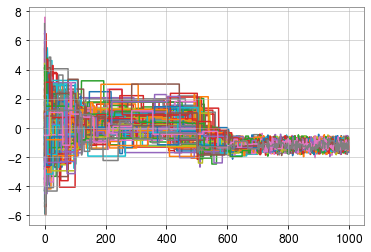

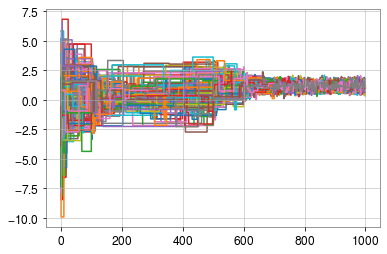

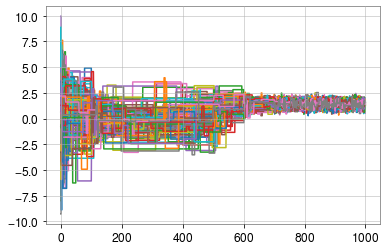

In [53]:
for i in range(0,q+1): #look at the chains
    plt.figure()
    plt.plot(sampler.chain[:,:,i])

In [54]:
samps=sampler.get_samples()

In [55]:
np.save('./data/CS_template_test_tomtemodel.npy', samps)

thinsamps = samps#[::10] optional thinning

In [56]:
samps.shape

(3572, 6)

In [57]:
#builds the timeseries reconstructions from the samples
reconst_td = build_reconstructions(W, thinsamps, post)
logls = gen_logls(samps, post)
snrs = gen_snrs(samps, post)

In [58]:
#samps = np.load('./data/CS_template_test_tomtemodel.npy')

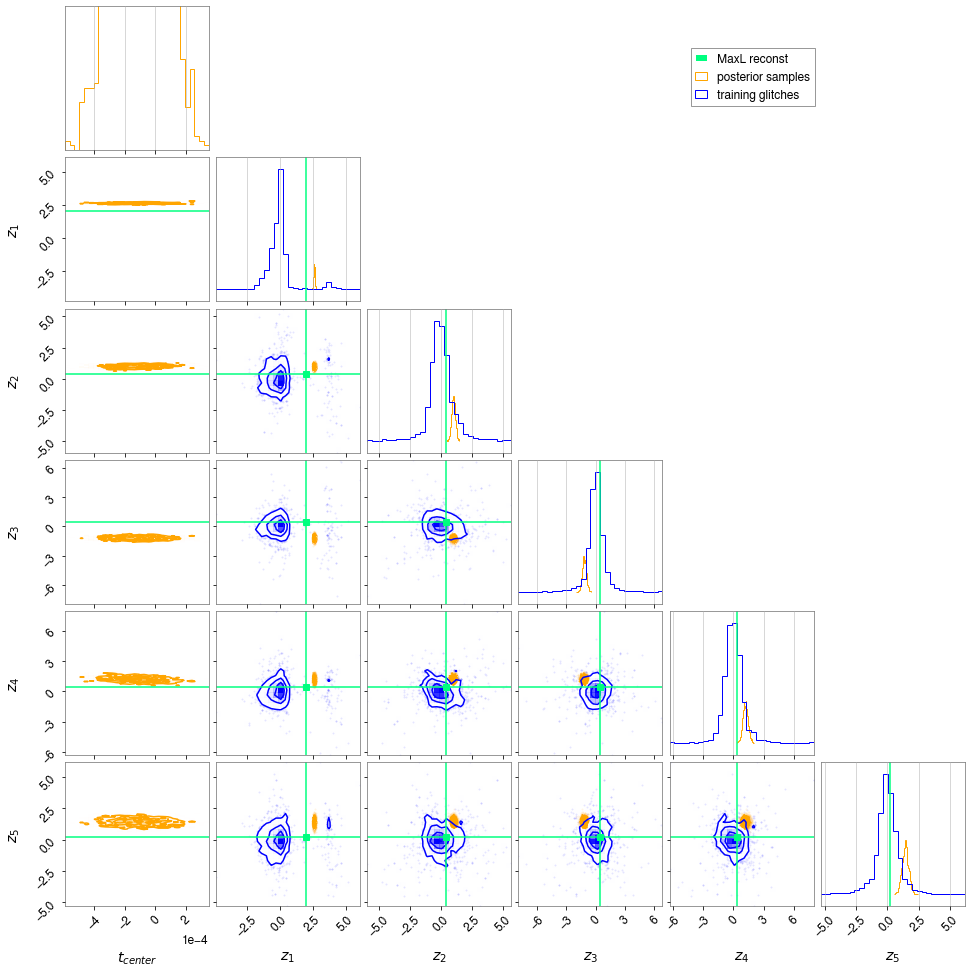

In [59]:
plot_corner_sample(Z, samps[::2], W, inj, t_ylim=30)

(-0.1, 0.1)

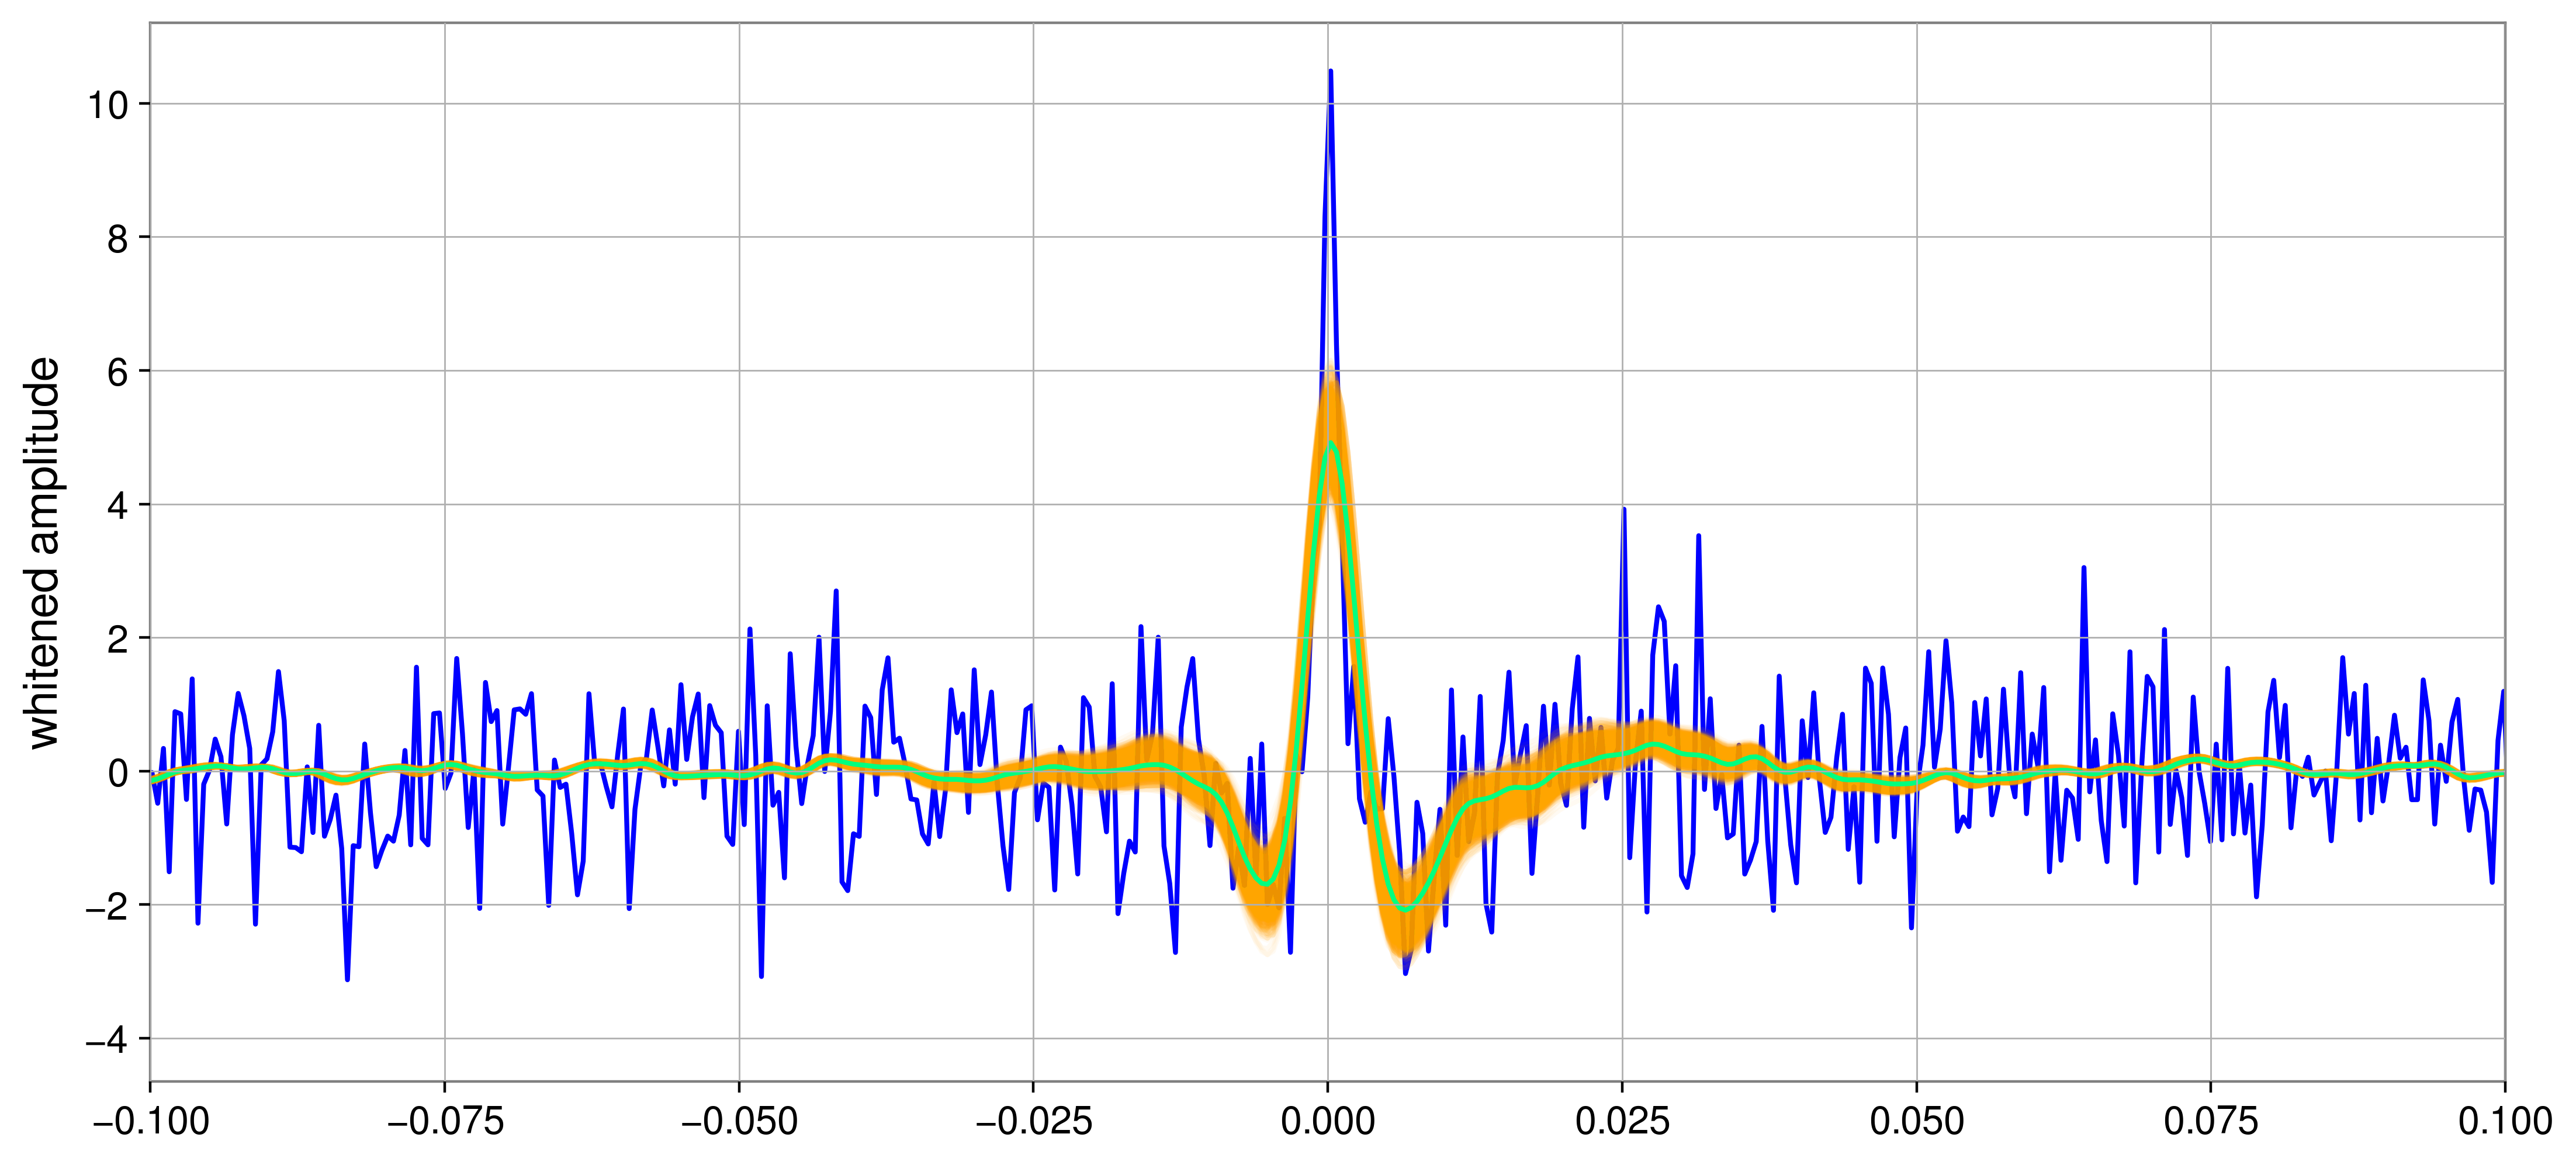

In [60]:
tlen = len(inj) / srate
times = np.linspace(-tlen / 2, tlen / 2, num=int(tlen * srate))

plt.figure(figsize=(13, 6), dpi=400)

plt.plot(times, inj, label='data', color = 'blue')
plt.plot(times, reconst_td.T, alpha=0.05, color='orange')
plt.plot(times, maxL_reconst(W, inj, fixed=False, gfrac=0.1, metric='ip'), color='springgreen', label='max$\mathcal{L}$ reconstruction');
plt.ylabel('whitened amplitude')
plt.xlim(-0.1, 0.1)

For any sampled event, we can calculate the deviance information criterion

In [63]:
dic(logls)

18539.46660184233

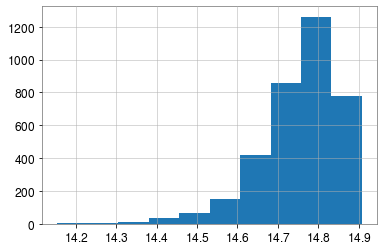

In [64]:
plt.hist(snrs);